In [1]:
import json
import sys
from mrtparse import *
import networkx as nx
import matplotlib.pyplot as plt

import os
import requests
import gzip
import shutil
import openai

from neo4j import GraphDatabase


In [2]:
server_url = "https://data.ris.ripe.net"
rrc_name = "rrc00"
year = "2017"
month = "09"
date = "01"
time = "0800"

zip_file_name = "bview.{}{}{}.{}.gz".format(year,month,date,time)
filename = "bview.{}{}{}.{}".format(year,month,date,time)

remote_url = server_url + "/" + rrc_name + "/" + year + "." + month + "/" + zip_file_name
print(remote_url)

https://data.ris.ripe.net/rrc00/2017.09/bview.20170901.0800.gz


In [3]:
r = requests.get(remote_url, allow_redirects=True)

if(r.status_code==200):

    ## Removing the zip file if it exists
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)

    ## Removing content file if it exists
    if os.path.isfile(filename):
        os.remove(filename)

    ## Obtaining the zip file
    with open(zip_file_name, 'wb') as f:
        f.write(r.content)

    ## Obtaining the content file
    with gzip.open(zip_file_name, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    ## Removing the zip file after extraction
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)
else:
    print('File does not exist')

## Creating graph in networkx

In [3]:
#edge_connections = ""

G = nx.DiGraph()
node_check = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        G.add_edge(curr_list[k+1],curr_list[k])
                        node_check.append(curr_list[k+1])
                        node_check.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    G.add_edge(curr_list[k+1],curr_list[k])
                    node_check.append(curr_list[k+1])
                    node_check.append(curr_list[k])


        i += 1

    if(i==20):
        break

#print(len(list(set(node_check))))

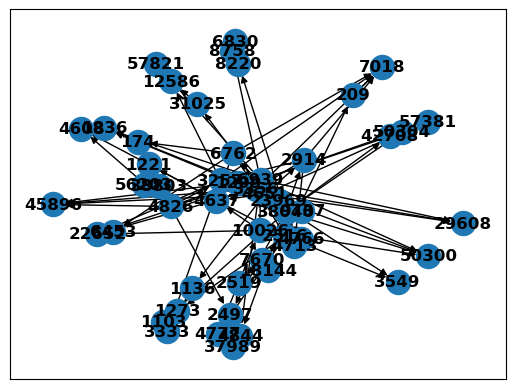

In [4]:
nx.draw_networkx(G, with_labels=True, font_weight='bold')

## Creating prompts from BGP data

In [5]:
formatted_string = ""
connect_list = []
node_list = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        connect_list.append('An arc exists strating from ' + curr_list[k+1] + " into " + curr_list[k])
                        node_list.append(curr_list[k+1])
                        node_list.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    connect_list.append('An arc exists starting from ' + curr_list[k+1] + " into " + curr_list[k])
                    node_list.append(curr_list[k+1])
                    node_list.append(curr_list[k])


        i += 1

    if(i==20):
        break

connect_list = list(set(connect_list))
node_list = list(set(node_list))
formatted_string = "\n".join(connect_list)
formatted_string_nodes = ",".join(node_list)
#print(formatted_string)

In [6]:
# ## Removing content file after reading
# if os.path.isfile(filename):
#     os.remove(filename)

## ChatGPT setup

In [7]:
import os
name = 'OPENAI_API_KEY'

key_location = "/Users/kiranjyothisheena/Documents/Kiran_Files/Capstone/OpenAPI_Key"
key_file = open(key_location, "r")
openapi_key = key_file.readline()

#secret = getpass.getpass("Enter the OpenAI API Key")
os.environ[name] = openapi_key
print(f"Have successfully set up {name} as an environment variable.")

Have successfully set up OPENAI_API_KEY as an environment variable.


In [8]:
# Define your API key (keep it secret!)
openai.api_key = openapi_key
API_KEY = openapi_key

In [9]:
from openai import OpenAI
client = OpenAI()

## Creating examples

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import random
import pickle

In [57]:

node_list = [5,10] ## List of possible number of nodes
no_of_graphs = 4 ## Number of graphs to be generated
graph_list = []

for i in range(no_of_graphs):
    curr_node_number = random.choice(node_list)
        
    prob_edge = 0.2 # Probability of edge creation (Increase it if you want more edges)
    curr_G = nx.fast_gnp_random_graph(n=curr_node_number,
                             p=prob_edge,
                             directed=True,
                             seed=123)
    graph_list.append(curr_G)


In [12]:
curr_file_name = "example_graphs_file.pkl"

with open(curr_file_name, 'wb') as f:
    pickle.dump(graph_list, f)

In [13]:
#### Run this block to load a pickle file

curr_file_name = "example_graphs_file.pkl"

with open(curr_file_name, 'rb') as f:
    graph_list = pickle.load(f)

In [14]:
## Describing a graph

def describe_graph(curr_graph,curr_num):
    
    """
    Function to describe a graph with nodes and edges
    
    input:
    curr_graph : A graph object
    curr_num : Integer to describe the graph
    
    output:
    graph_desc: A string object with description about the graph
    """
    
    
    graph_desc = """"""

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes = [str(each_node) for each_node in nodes]
    edges = [('An arc exists starting from ' + str(curr_edge[0]) + " into " + str(curr_edge[1])) for curr_edge in edges]

    graph_desc = graph_desc + """
    Graph {} has nodes {}
    and the edges are described as follows

    {}
    """.format(str(curr_num),','.join(nodes),'\n  '.join(edges))

    return graph_desc

In [15]:
def describe_indegree(curr_graph):

    indegree_desc = """ 
    The indegree of the nodes are as follows 
    """

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes_str = [str(each_node) for each_node in nodes]

    for k in range(len(nodes)):

        curr_node_str = nodes_str[k]
        curr_node = nodes[k]

        curr_indegree = curr_graph.in_degree(curr_node)

        indegree_desc = indegree_desc + """
        In degree of node {} is {}""".format(curr_node_str, str(curr_indegree))
    
    return indegree_desc

In [16]:
def describe_outdegree(curr_graph):

    indegree_desc = """ 
    The outdegree of the nodes are as follows 
    """

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes_str = [str(each_node) for each_node in nodes]

    for k in range(len(nodes)):

        curr_node_str = nodes_str[k]
        curr_node = nodes[k]

        curr_indegree = curr_graph.out_degree(curr_node)

        indegree_desc = indegree_desc + """
        Out degree of node {} is {}""".format(curr_node_str, str(curr_indegree))
    
    return indegree_desc

In [95]:

## To generate prompts for indegree


graph_desc = """"""
i = 0

for each_graph in graph_list:
    graph_desc = graph_desc + describe_graph(each_graph,i) + describe_indegree(each_graph) + "\n"
    i+=1
    


In [96]:
print(graph_desc)


    Graph 0 has nodes 0,1,2,3,4,5,6,7,8,9
    and the edges are described as follows

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 0 into 7
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 6
  An arc exists starting from 1 into 9
  An arc exists starting from 1 into 0
  An arc exists starting from 2 into 3
  An arc exists starting from 2 into 6
  An arc exists starting from 2 into 7
  An arc exists starting from 2 into 1
  An arc exists starting from 3 into 9
  An arc exists starting from 3 into 2
  An arc exists starting from 4 into 8
  An arc exists starting from 4 into 9
  An arc exists starting from 5 into 8
  An arc exists starting from 6 into 1
  An arc exists starting from 6 into 2
  An arc exists starting from 6 into 3
  An arc exists starting from 7 into 8
  An arc exists starting from 7 into 9
  An arc exists starting from 7 into 4
  An arc exists starting from 7 into 5
  An arc exist

## Prompting

### Without nodes

In [71]:
system_prompt = """
You are an assistant that is an expert in graph operations that should memorize the inputs given initially without forgetting them. These
would contain information about a graph. Using the given information you should answer the questions that follow.
Do not add any additional information that is not explicitly provided in the latest prompt.
I repeat, do not add any information that is not explicitly given.
"""
# context = 'A is connected to D with a cost of 100, A is connected to C with a cost of 50, A is connected to B with a cost of 50, B is connected to D with a cost of 40, C is connected to E with a cost of 80, C is connected to D with a cost of 40, D is connected to A with a cost of 69, D is connected to F with a cost of 80, D is connected to E with a cost of 30, E is connected to F with a cost of 40'
context = """
In a graph structure, we define the arc relation as follows.
An arc exists starting from A into B implies node A and node B exists and there exists an arc
which is outbound from A and inbound to B. 

Q. A graph is defined using the following arc relations

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 0
  An arc exists starting from 2 into 3
  An arc exists starting from 3 into 1
  An arc exists starting from 4 into 0

What is the In degree of node 0?

A. Let's work this out in a step by step way to be sure we have the right answer.
The arcs which are connected into node 0 are 1->0 and 4->0. The total number of arcs thus connected into 
node 0 is 2. Thus, the In degree of node 0 is 2.

Q. A graph is defined using the following arc relations

  An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 0 into 7
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 6
  An arc exists starting from 1 into 9
  An arc exists starting from 1 into 0
  An arc exists starting from 2 into 3
  An arc exists starting from 2 into 6
  An arc exists starting from 2 into 7
  An arc exists starting from 2 into 1
  An arc exists starting from 3 into 9
  An arc exists starting from 3 into 2
  An arc exists starting from 4 into 8
  An arc exists starting from 4 into 9
  An arc exists starting from 5 into 8
  An arc exists starting from 6 into 1
  An arc exists starting from 6 into 2
  An arc exists starting from 6 into 3
  An arc exists starting from 7 into 8
  An arc exists starting from 7 into 9
  An arc exists starting from 7 into 4
  An arc exists starting from 7 into 5
  An arc exists starting from 8 into 9
  An arc exists starting from 9 into 1
  An arc exists starting from 9 into 5
  An arc exists starting from 9 into 7
  
What is the In degree of node 1?

A. Let's work this out in a step by step way to be sure we have the right answer.
The arcs which are connected into node 1 are 0->1,2->1,6->1,9->1. The total number of arcs thus connected into 
node 1 is 4. Thus, the In degree of node 1 is 4.

Q. A graph is defined using the following arc relations

""" + formatted_string



def generate_user_prompt(question, context):
    return f"""
        {context}
        
        {question}
        
        A. Let's work this out in a step by step way to be sure we have the right answer.
       """

In [72]:
import openai

def get_gpt3_response(system_prompt, prompt, context, api_key, model="gpt-3.5-turbo"):
    """
    Send a request to the OpenAI Chat API and get a response from the model.
    
    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".
    
    Returns:
        str: The model's response.
    """
    
    #print(generate_user_prompt(prompt, context))
   
    
    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": generate_user_prompt(prompt, context)}
    ]
    
    # Use the OpenAI Python client to send the request
    response = client.chat.completions.create(
        model=model,
        messages=messages
    )
    
    # Extract the response text and return
    return response.choices[0].message.content

In [41]:
# Example usage
question = "What is the In degree of node 29608"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 29608 are 6939->29608, 4651->29608. The total number of arcs thus connected into node 29608 is 2. Thus, the In degree of node 29608 is 2.


In [42]:
print(G.in_degree('29608'))

3


In [43]:
# Example usage
question = "What is the In degree of node 50300?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY,model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 50300 are 38040->50300 and 4651->50300. The total number of arcs thus connected into 
node 50300 is 2. Thus, the In degree of node 50300 is 2.


In [44]:
print(G.in_degree('50300'))

4


In [45]:
# Example usage
question = "What is the In degree of node 45896?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 45896 are 6939->45896, 3356->45896, 4651->45896. The total number of arcs thus connected into node 45896 is 3. Thus, the In degree of node 45896 is 3.


In [46]:
print(G.in_degree('45896'))

4


In [47]:
# Example usage
question = "What is the In degree of node 18144?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

Based on the given information, there are no arcs starting from any other node and ending at node 18144. Therefore, the In degree of node 18144 is 0.


In [48]:
print(G.in_degree('18144'))

0


In [49]:
# Example usage
question = "What is the In degree of node 4651?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 4651 are 
3356->4651, 6939->4651, 4651->31025, 4637->4651, 23969->4651, 4651->50300, 2914->4651, 4651->45896, 2516->4651, and 38040->4651.
The total number of arcs thus connected into node 4651 is 10. Thus, the In degree of node 4615 is 10.


In [50]:
print(G.in_degree('4651'))

1


In [54]:
# Example usage
question = "What is the In degree of node 6762?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 6762 are 6762->3356, 6762->4637, 6762->6453, and 6762->174. The total number of arcs thus connected into node 6762 is 4. Thus, the In degree of node 6762 is 4.


In [53]:
print(G.in_degree('6762'))

1


In [52]:
# Example usage
question = "What is the In degree of node 7018?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 7018 are 3356->7018, 3257->7018, and 2914->7018. 
The total number of arcs thus connected into node 7018 is 3. 
Thus, the In degree of node 7018 is 3.


In [51]:
print(G.in_degree('7018'))

5


In [73]:
# Example usage
question = "What is the In degree of node 38040?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 38040 are 38040->8220, 38040->50300, 38040->4844, 38040->1103, 38040->1299,
38040->2914, 38040->50304, 38040->42708. The total number of arcs thus connected into node 38040 is 8. Thus, the In degree of node 38040 is 8.


In [69]:
print(G.in_degree('38040'))

2


In [74]:
# Example usage
question = "What is the In degree of node 8220?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected into node 8220 are 38040->8220. The total number of arcs thus connected into node 8220 is 1. Thus, the In degree of node 8220 is 1.


## Out degree

In [58]:
## To generate prompts for indegree


graph_desc = """"""
i = 0

for each_graph in graph_list:
    graph_desc = graph_desc + describe_graph(each_graph,i) + describe_outdegree(each_graph) + "\n"
    i+=1
    

In [59]:
print(graph_desc)


    Graph 0 has nodes 0,1,2,3,4
    and the edges are described as follows

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 0
  An arc exists starting from 2 into 3
  An arc exists starting from 3 into 1
  An arc exists starting from 4 into 0
     
    The outdegree of the nodes are as follows 
    
        Out degree of node 0 is 2
        Out degree of node 1 is 2
        Out degree of node 2 is 1
        Out degree of node 3 is 1
        Out degree of node 4 is 1

    Graph 1 has nodes 0,1,2,3,4
    and the edges are described as follows

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 0
  An arc exists starting from 2 into 3
  An arc exists starting from 3 into 1
  An arc exists starting from 4 into 0
     
    The outdegree of the nodes are as follows 
    
        Ou

In [60]:
system_prompt = """
You are an assistant that is an exper in graph operations that should memorize the inputs given initially without forgetting them. These
would contain information about a graph. Using the given information you should answer the questions that follow.
Do not add any additional information that is not explicitly provided in the latest prompt.
I repeat, do not add any information that is not explicitly given.
"""
# context = 'A is connected to D with a cost of 100, A is connected to C with a cost of 50, A is connected to B with a cost of 50, B is connected to D with a cost of 40, C is connected to E with a cost of 80, C is connected to D with a cost of 40, D is connected to A with a cost of 69, D is connected to F with a cost of 80, D is connected to E with a cost of 30, E is connected to F with a cost of 40'
context = """
In a graph structure, we define the arc relation as follows.
An arc exists starting from A into B implies node A and node B exists and there exists an arc
which is outbound from A and inbound to B. 

Q. A graph is defined using the following arc relations

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 0
  An arc exists starting from 2 into 3
  An arc exists starting from 3 into 1
  An arc exists starting from 4 into 0

What is the Out degree of node 0?

A. Let's work this out in a step by step way to be sure we have the right answer.
The arcs which are connected from node 0 are 0->1 and 0->2. The total number of arcs thus connected from
node 0 is 2. Thus, the Out degree of node 0 is 2.

Q. A graph is defined using the following arc relations

  An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 0 into 7
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 6
  An arc exists starting from 1 into 9
  An arc exists starting from 1 into 0
  An arc exists starting from 2 into 3
  An arc exists starting from 2 into 6
  An arc exists starting from 2 into 7
  An arc exists starting from 2 into 1
  An arc exists starting from 3 into 9
  An arc exists starting from 3 into 2
  An arc exists starting from 4 into 8
  An arc exists starting from 4 into 9
  An arc exists starting from 5 into 8
  An arc exists starting from 6 into 1
  An arc exists starting from 6 into 2
  An arc exists starting from 6 into 3
  An arc exists starting from 7 into 8
  An arc exists starting from 7 into 9
  An arc exists starting from 7 into 4
  An arc exists starting from 7 into 5
  An arc exists starting from 8 into 9
  An arc exists starting from 9 into 1
  An arc exists starting from 9 into 5
  An arc exists starting from 9 into 7
  
What is the Out degree of node 1?

A. Let's work this out in a step by step way to be sure we have the right answer.
The arcs which are connected from node 1 are 1->3,1->6,1->9,1->0. The total number of arcs thus connected from 
node 1 is 4. Thus, the Out degree of node 1 is 4.

Q. A graph is defined using the following arc relations

""" + formatted_string



def generate_user_prompt(question, context):
    return f"""
        {context}
        
        {question}
        
        A. Let's work this out in a step by step way to be sure we have the right answer.
       """

In [61]:
# Example usage
question = "What is the Out degree of node 4651?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected from node 4651 are:
4651 -> 4766
4651 -> 31025
4651 -> 3356
4651 -> 1836
4651 -> 2914
4651 -> 50304
4651 -> 45896
4651 -> 50300
4651 -> 4637
4651 -> 4651
The total number of arcs thus connected from node 4651 is 9.
Thus, the Out degree of node 4651 is 9.


In [62]:
print(G.out_degree('4651'))

11


In [65]:
# Example usage
question = "What is the Out degree of node 29608?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected from node 29608 are 29608->6939. The total number of arcs thus connected from 
node 29608 is 1. Thus, the Out degree of node 29608 is 1.


In [63]:
print(G.out_degree('29608'))

0


In [67]:
# Example usage
question = "What is the Out degree of node 2914?"
context_info = context
response = get_gpt3_response(system_prompt, question, context_info, API_KEY, model = "gpt-3.5-turbo")
print(response)

The arcs which are connected from node 2914 are 2914->3257 and 2914->4713. The total number of arcs thus connected from 
node 2914 is 2. Thus, the Out degree of node 2914 is 2.


In [66]:
print(G.out_degree('2914'))

4


In [68]:
for each_node in G.nodes():
    print(each_node,':(',G.in_degree(each_node),',',G.out_degree(each_node),')')

42708 :( 1 , 2 )
50304 :( 4 , 1 )
3356 :( 5 , 7 )
45896 :( 4 , 0 )
6830 :( 0 , 1 )
8758 :( 3 , 0 )
6939 :( 2 , 10 )
4826 :( 1 , 6 )
38803 :( 1 , 2 )
56203 :( 0 , 1 )
2497 :( 2 , 1 )
4777 :( 3 , 0 )
4844 :( 2 , 1 )
37989 :( 1 , 0 )
4608 :( 2 , 0 )
57821 :( 2 , 0 )
3549 :( 2 , 0 )
1299 :( 2 , 2 )
29608 :( 3 , 0 )
22652 :( 5 , 0 )
57381 :( 3 , 0 )
50300 :( 4 , 0 )
3257 :( 4 , 4 )
7018 :( 5 , 0 )
1836 :( 4 , 0 )
3333 :( 4 , 0 )
2516 :( 4 , 5 )
4637 :( 4 , 2 )
1221 :( 2 , 2 )
10026 :( 1 , 4 )
2519 :( 1 , 2 )
7670 :( 1 , 2 )
18144 :( 0 , 1 )
209 :( 1 , 1 )
1273 :( 1 , 1 )
38040 :( 2 , 10 )
9737 :( 0 , 1 )
6762 :( 1 , 5 )
12586 :( 2 , 1 )
2914 :( 2 , 4 )
8220 :( 1 , 1 )
4713 :( 1 , 1 )
174 :( 1 , 1 )
1103 :( 1 , 1 )
4651 :( 1 , 11 )
23969 :( 0 , 2 )
4766 :( 1 , 1 )
31025 :( 1 , 1 )
1136 :( 1 , 1 )
6453 :( 1 , 1 )
